In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
df = pd.read_csv('/content/drive/My Drive/NITD Internship/nitdata.csv', index_col='Date', parse_dates=True)

In [10]:
df.head()

,Temperature,Humidity,Carbon Monoxide,Nitrogen Dioxide,Dust (PM2.5),Dust (PM10)
Date,,,,,,
2020-05-22 18:55:07,27,66,46,0.27,44,61
2020-05-22 18:55:01,27,66,46,0.27,43,60
2020-05-22 18:54:57,27,66,46,0.27,43,60
2020-05-22 18:54:51,27,66,46,0.27,43,60
2020-05-22 18:54:47,27,66,46,0.27,43,60


In [0]:
# converting all 0 in df to NaN
df.replace(to_replace=0, value=np.nan, inplace=True)
# filling them with mean
df.fillna(df.mean(), inplace=True)
df.columns = ['temp', 'humidity', 'co', 'no2' , 'dust1', 'dust2']

In [0]:
# keeping only one occurence of date time and merging duplicates by doing mean of them
# and also sorting the index in ascending order
df = df.groupby('Date').mean()

In [13]:
df.head(4)

,temp,humidity,co,no2,dust1,dust2
Date,,,,,,
2020-05-16 02:05:21,23,67,43,1.43,23.0,32.0
2020-05-16 02:05:26,23,67,44,1.43,23.0,32.0
2020-05-16 02:06:01,23,67,44,1.43,23.0,32.0
2020-05-16 02:06:18,23,67,44,1.43,24.0,34.0


In [0]:
dataset = pd.DataFrame()
dataset['temp'] = df.temp.resample('H').mean()
dataset['humidity'] = df.humidity.resample('H').mean()
dataset['co'] = df.co.resample('H').mean()
dataset['no2'] = df.no2.resample('H').mean()
dataset['dust1'] = df.dust1.resample('H').mean()
dataset['dust2'] = df.dust2.resample('H').mean()

In [15]:
dataset.head(4)

,temp,humidity,co,no2,dust1,dust2
Date,,,,,,
2020-05-16 02:00:00,22.950959,67.974414,43.505330,1.456759,25.574704,35.978933
2020-05-16 03:00:00,22.202797,72.304196,43.569930,1.437290,25.710770,36.077272
2020-05-16 04:00:00,22.026984,74.628571,43.969841,1.325508,56.169221,78.278348
2020-05-16 05:00:00,22.000000,75.634615,44.000000,1.131521,89.782406,124.723986


In [16]:
dataset.isnull().sum()

temp        0
humidity    0
co          0
no2         0
dust1       0
dust2       0
dtype: int64

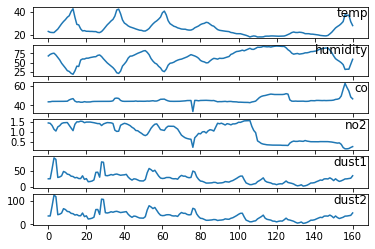

In [17]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [18]:
dataset.index.freq

<Hour>

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

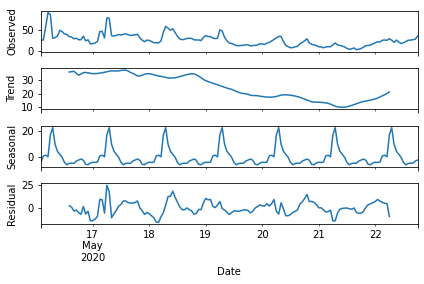

In [20]:
results = seasonal_decompose(dataset['dust1'])
results.plot();

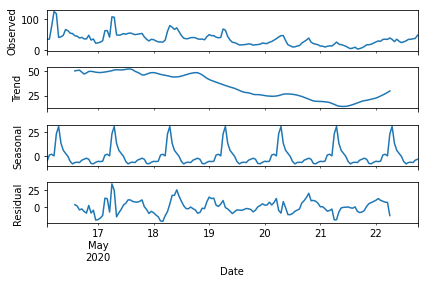

In [21]:
results = seasonal_decompose(dataset['dust2'])
results.plot();

In [0]:
def convert(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    if type(data) is not list:
        n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    total = pd.concat(cols, axis=1)
    total.columns = names
    if dropnan:
        total.dropna(inplace=True)
    return total

In [23]:
# predicting for dust1 i.e Dust (PM2.5)
dataset1 = dataset.drop('dust2', axis=1)
dataset1.head(4)

,temp,humidity,co,no2,dust1
Date,,,,,
2020-05-16 02:00:00,22.950959,67.974414,43.505330,1.456759,25.574704
2020-05-16 03:00:00,22.202797,72.304196,43.569930,1.437290,25.710770
2020-05-16 04:00:00,22.026984,74.628571,43.969841,1.325508,56.169221
2020-05-16 05:00:00,22.000000,75.634615,44.000000,1.131521,89.782406


In [0]:
from sklearn.preprocessing import MinMaxScaler
values = dataset1.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)
reframed = convert(scaled_data)

In [0]:
reframed.drop(reframed.columns[[5,6,7,8]], axis=1, inplace=True)

In [26]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var5(t)
1,0.196735,0.648653,0.344431,0.917015,0.258142,0.259714
2,0.166436,0.704367,0.346663,0.903566,0.259714,0.611632
3,0.159316,0.734277,0.360482,0.826347,0.611632,1.000000
4,0.158223,0.747222,0.361524,0.692341,1.000000,0.945853
5,0.218245,0.682512,0.361710,0.630232,0.945853,0.306160


In [28]:
# split into train and test sets
values = reframed.values
n_train_hours = 160 - 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(136, 1, 5) (136,) (24, 1, 5) (24,)


In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [33]:
history = model.fit(train_X, train_y, batch_size=32, epochs=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 136 samples, validate on 24 samples
Epoch 1/50
 - 0s - loss: 0.0714 - val_loss: 0.0735
Epoch 2/50
 - 0s - loss: 0.0704 - val_loss: 0.0719
Epoch 3/50
 - 0s - loss: 0.0695 - val_loss: 0.0716
Epoch 4/50
 - 0s - loss: 0.0688 - val_loss: 0.0719
Epoch 5/50
 - 0s - loss: 0.0682 - val_loss: 0.0713
Epoch 6/50
 - 0s - loss: 0.0674 - val_loss: 0.0685
Epoch 7/50
 - 0s - loss: 0.0664 - val_loss: 0.0654
Epoch 8/50
 - 0s - loss: 0.0655 - val_loss: 0.0652
Epoch 9/50
 - 0s - loss: 0.0650 - val_loss: 0.0646
Epoch 10/50
 - 0s - loss: 0.0643 - val_loss: 0.0635
Epoch 11/50
 - 0s - loss: 0.0637 - val_loss: 0.0615
Epoch 12/50
 - 0s - loss: 0.0630 - val_loss: 0.0598
Epoch 13/50
 - 0s - loss: 0.0623 - val_loss: 0.0593
Epoch 14/50
 - 0s - loss: 0.0617 - val_loss: 0.0582
Epoch 15/50
 - 0s - loss: 0.0612 - val_loss: 0.0578
Epoch 16/50
 - 0s - loss: 0.0606 - val_loss: 0.0547
Epoch 17/50
 - 0s - loss: 0.0599 - val_loss: 0.0530
Epoch 18/50
 - 0s - loss: 0.0593 - val_loss: 0.0512
Epoch 19/50
 - 0s - loss: 0.

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


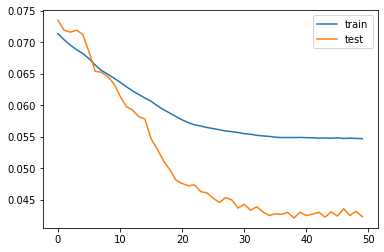

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
yhat = model.predict(test_X)

In [0]:
# changed from 3d back to 2d
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [0]:
inv_yhat = np.concatenate((test_X[:,:4], yhat), axis=1)

In [0]:
# invert scaling for forecast
inv_yhat = scaler.inverse_transform(inv_yhat)

In [0]:
inv_yhat = inv_yhat[:,4]

In [0]:
test_y = test_y.reshape((len(test_y), 1))

In [0]:
# invert scaling for actual
inv_y = np.concatenate((test_X[:,:4], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [0]:
inv_y = inv_y[:,4]

In [78]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.417


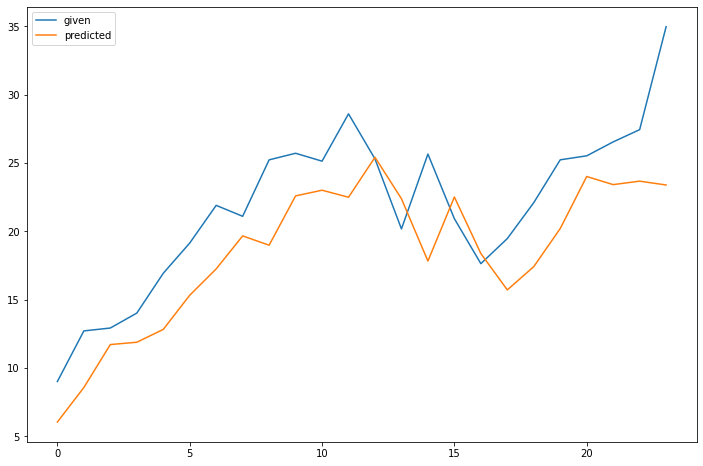

In [79]:
df1 = pd.DataFrame(data=inv_y)
df1['predicted'] = pd.DataFrame(data=inv_yhat)
df1.columns = ['given', 'predicted']
df1.plot(figsize=(12,8));